<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99c_insurance_federated_wrapup_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Insurance

Open

- [ ] RSquared for FL, but it is only available in tf-nightly and the installation broke the env
- [ ] cache result
- [x] centralized: does CSV Logger work with TFF? Or instead save the hist manually as csv
- [x] logging/caching federated
- [ ] document input and outputs in FLutils
- [ ] move to and test colab

## Prerequisites
---

In [1]:
# Setup colab if needed

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("COLAB? {}".format(IN_COLAB))

if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon/_dev

    # pull (the currenct version of the repo)
    !git pull

    !pip install -q tensorflow-federated==0.56.0
    # or maybe !pip install -r requirements.txt


COLAB? True
Cloning into 'fl-official-statistics-addon'...
remote: Enumerating objects: 1876, done.
remote: Counting objects: 100% (1058/1058), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 1876 (delta 619), reused 995 (delta 563), pack-reused 818
Receiving objects: 100% (1876/1876), 56.30 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (979/979), done.
Updating files: 100% (636/636), done.
/content/fl-official-statistics-addon
Already up to date.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 28.5 MB/s eta 0:00:00


In [2]:
# python version
!python --version
# tested 3.9.* or 3.10.*.

Python 3.10.11


In [3]:
# library versions
!pip list | grep tensorflow
# tensorflow                    2.12.0
# tensorflow-federated          0.56.0

tensorflow                    2.12.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-gcs-config         2.12.0
tensorflow-hub                0.13.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [11]:
%cd _dev
%ls

/content/fl-official-statistics-addon/_dev
00_initial_results.ipynb               99a_insurance_centralized_wrapup.ipynb
00_intro_code_methods.ipynb            99b_insurance_federated_wrapup.ipynb
01_insurance_prep_eda_baselines.ipynb  FLutils.py
02_insurance_DNN.ipynb                 __pycache__/
03_insurance_federated.ipynb


In [12]:
# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


In [14]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model,train_fed
#import FLutils

# logging path
log_path = '../output/experiments' 

### Data preperation
---

In [15]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [16]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']#[:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


In [17]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


### Evaluation split
---

In [18]:
# create evaluation splits
# ========================

nreps, nfolds = 10, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [50, 50, 50, 50]


### Parameter
---

In [19]:
n_evals  =   3#5 * nfolds # up to nfolds * nreps
n_epochs = 10          # for centralized training
n_rounds =  10          # federation rounds

## Federated Learning
---

In [20]:
experiment_name = '03_federated'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

In [21]:
# define model architecture
def keras_blueprint(compile = False, nfeatures = len(features[:5])):
    if nfeatures == None: nfeatures = len(features)
    
    return create_keras_model(
        nfeatures = nfeatures, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

# loss = mae -> overfitting?

keras_blueprint().summary()
keras_blueprint(compile=True).get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

### FED Train 

In [22]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(n_evals)):

    rep  = int(eval_ind / nfolds)
    fold = int(eval_ind % nfolds)
    id = "r" + str(rep) + "f" + str(fold)
    #print('======= rep %s - fold %s  =======' % (rep, fold))


    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features[:5]], train_data[target])) 
        eval_data_fed.append( prep_fed_test( eval_data[features[:5]], eval_data[target]))
        
    # train
    #with tf.device('/device:gpu:0'): # possibly needed for colab
    result = train_fed(
        model = model_fn(
            keras_creator = keras_blueprint,
            loss = tf.losses.MeanSquaredError()
        ),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = n_rounds,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = False
    )

    # caching
    pd.DataFrame(result['history']).to_csv(experiment_path + "logs/" + id + '_log.csv', sep = ";")

    model = keras_blueprint()
    model_weights = result['process'].get_model_weights(result['state'])
    model_weights.assign_weights_to(model)
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    # load with e.g. 
    # model = keras_blueprint(compile = True)
    # model.load_weights(experiment_path + 'models/r0f0_weights.h5')
    # model.weights

    results_fed.append(result)

100%|██████████| 3/3 [01:19<00:00, 26.59s/it]


In [23]:
# show final train result
table = pd.DataFrame([result['history'][-1] for result in results_fed])
table.describe().to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,3.00,3.0,3.0,3.0,3.0,3.00,3.0,3.0,3.0,3.0
mean,5102.82,59746692.0,59985856.0,48100.0,378.0,12710.01,312987552.0,317103200.0,108.0,4.0
std,394.09,7520049.0,7568775.5,0.0,0.0,898.07,32597964.0,33968452.0,0.0,0.0
min,4764.47,54933580.0,55148116.0,48100.0,378.0,12058.88,289852800.0,293246976.0,108.0,4.0
25%,4886.47,55413852.0,55624694.0,48100.0,378.0,12197.75,294346816.0,297657536.0,108.0,4.0
50%,5008.48,55894124.0,56101272.0,48100.0,378.0,12336.61,298840832.0,302068096.0,108.0,4.0
75%,5272.00,62153246.0,62404728.0,48100.0,378.0,13035.57,324554928.0,329031328.0,108.0,4.0
max,5535.52,68412368.0,68708184.0,48100.0,378.0,13734.54,350269024.0,355994560.0,108.0,4.0


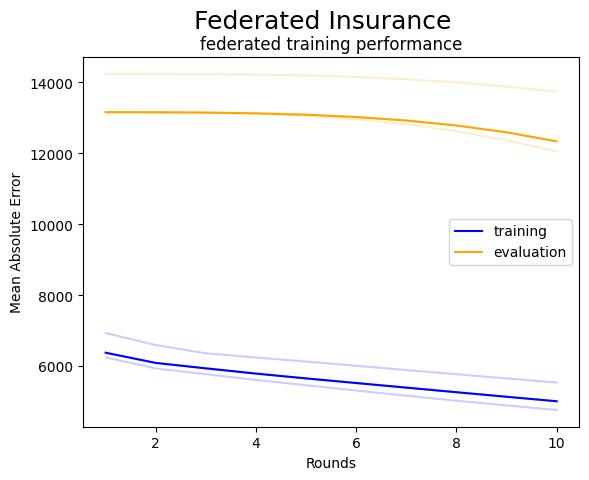

In [24]:
# plot train result

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()

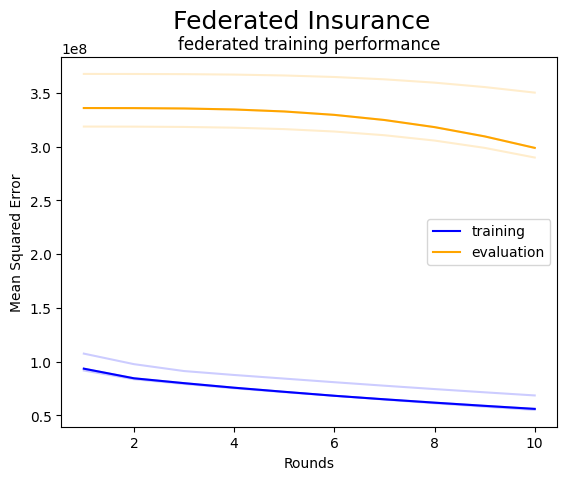

In [25]:
# plot train result

y = np.array([[hist['mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_squared_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Squared Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mse.png')
plt.show()

### FED Test

In [26]:
# compute test 
results_fed_test = []

model = keras_blueprint(compile = True)


for i in tqdm.tqdm(range(len(results_fed))):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features[:5]]
    y_test = test_data[target]

    # calculate test performance
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


In [27]:
# show test results
table2 = pd.DataFrame(results_fed_test)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)

table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")

table_all.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
mean_absolute_error,5.102821e+03,3.940906e+02,4.764465e+03,4.886471e+03,5.008476e+03,5.271998e+03,5.535521e+03
mean_squared_error,5.974669e+07,7.520049e+06,5.493358e+07,5.541385e+07,5.589412e+07,6.215325e+07,6.841237e+07
loss,5.998586e+07,7.568776e+06,5.514812e+07,5.562469e+07,5.610127e+07,6.240473e+07,6.870818e+07
num_examples,4.810000e+04,0.000000e+00,4.810000e+04,4.810000e+04,4.810000e+04,4.810000e+04,4.810000e+04
num_batches,3.780000e+02,0.000000e+00,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02,3.780000e+02
val_mean_absolute_error,1.271001e+04,8.980676e+02,1.205888e+04,1.219775e+04,1.233661e+04,1.303557e+04,1.373454e+04
val_mean_squared_error,3.129876e+08,3.259796e+07,2.898528e+08,2.943468e+08,2.988408e+08,3.245549e+08,3.502690e+08
val_loss,3.171032e+08,3.396845e+07,2.932470e+08,2.976575e+08,3.020681e+08,3.290313e+08,3.559946e+08
val_num_examples,1.080000e+02,0.000000e+00,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
val_num_batches,4.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00


## Centralized DNN
---

Using 9 Features.

In [28]:
experiment_name = '02_central_new'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

### CTR Train
---

In [29]:
%%time
# compute train

results_ctr = []

for i in range(n_evals):

    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    rep  = int(i / nfolds)
    fold = int(i % nfolds)
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features[:9]] # include regions
    y_train = data_train[target]

    model = keras_blueprint(nfeatures = 9, compile = True)
    
    hist = train_model(
        model, X_train, y_train,
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42
    )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')

    results_ctr.append(hist)


======= rep 0 - fold 0  =======
R^2  = 0.7432,  time = 20.6 sec
======= rep 0 - fold 1  =======
R^2  = 0.7740,  time = 21.0 sec
======= rep 0 - fold 2  =======
R^2  = 0.7795,  time = 20.6 sec
CPU times: user 30.7 s, sys: 991 ms, total: 31.7 s
Wall time: 1min 2s


In [30]:
# show train results
table = pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
)

table.describe()[1:].to_csv(experiment_path + "results/performance_train_overview.csv", sep = ";")
table.round(2)

,loss,mae,mean_squared_error,r2_score,val_loss,val_mae,val_mean_squared_error,val_r2_score
0,40933624.0,4904.03,40933624.0,74.32,43234324.0,4133.67,43234324.0,60.43
1,35914268.0,4121.06,35914268.0,77.40,40684432.0,3829.31,40684432.0,62.80
2,35020124.0,3792.77,35020124.0,77.95,41978116.0,3941.80,41978116.0,61.15


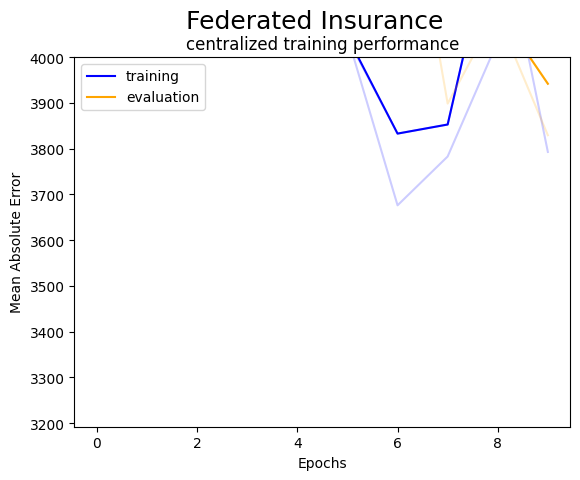

In [31]:
# plot train result
y1 = np.array([hist.history["mae"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_mae"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([None, 4000])

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_mae.png')
plt.show()


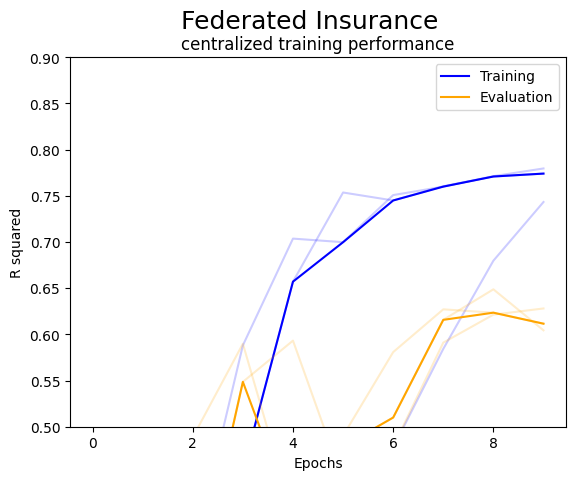

In [32]:
# plot train result
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .2)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'Training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .2)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'Evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epochs")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize = 18)
plt.title('centralized training performance')
plt.legend()
plt.savefig(experiment_path + 'results/training_performance_rsq.png')
plt.show()



### CTR Test
---

In [33]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(
    3
    #nfolds * nreps - 40
    )):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features[:9]]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


In [34]:
# show test results
table2 = pd.DataFrame(results_test_ctr)
table2 = table2.set_axis(['test_'+ col for col in table2.columns], axis = 1)


table2.describe()[1:].to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")

table_all = pd.concat([table, table2], axis = 1)
table_all.describe()[1:].to_csv(experiment_path + "results/performance_overview.csv", sep = ";")
table_all.to_csv(experiment_path + "results/performance.csv", sep = ";")
table_all.describe()[1:].transpose().round(4)

,mean,std,min,25%,50%,75%,max
loss,3.728934e+07,3.187552e+06,3.502012e+07,3.546720e+07,3.591427e+07,3.842395e+07,4.093362e+07
mae,4.272619e+03,5.709223e+02,3.792767e+03,3.956915e+03,4.121064e+03,4.512546e+03,4.904028e+03
mean_squared_error,3.728934e+07,3.187552e+06,3.502012e+07,3.546720e+07,3.591427e+07,3.842395e+07,4.093362e+07
r2_score,7.655520e+01,1.956100e+00,7.431940e+01,7.585720e+01,7.739500e+01,7.767310e+01,7.795120e+01
val_loss,4.196562e+07,1.274992e+06,4.068443e+07,4.133127e+07,4.197812e+07,4.260622e+07,4.323432e+07
val_mae,3.968258e+03,1.538958e+02,3.829308e+03,3.885553e+03,3.941799e+03,4.037734e+03,4.133668e+03
val_mean_squared_error,4.196562e+07,1.274992e+06,4.068443e+07,4.133127e+07,4.197812e+07,4.260622e+07,4.323432e+07
val_r2_score,6.146130e+01,1.213000e+00,6.043310e+01,6.079240e+01,6.115170e+01,6.197540e+01,6.279900e+01
test_loss,4.611005e+07,8.653277e+05,4.517065e+07,4.572778e+07,4.628490e+07,4.657975e+07,4.687460e+07
test_mae,4.442663e+03,1.637535e+02,4.319945e+03,4.349693e+03,4.379441e+03,4.504022e+03,4.628603e+03
